# Pill Identification Pipeline
Implementation based on: "An Accurate Deep Learning-Based System for Automatic Pill Identification: Model Development and Validation" (Heo et al., 2023)

Pipeline: **Raw Image → YOLO (Imprint Detection) → ResNet (Feature Recognition) → RNN (Imprint Correction) → Database Retrieval**

## 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from ultralytics import YOLO
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from rnn_model import Seq2SeqWithAttention
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device(
    'mps' if torch.backends.mps.is_available() else
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f'Using device: {device}')

Using device: mps


## 2. Define ResNet Model

In [2]:
class MultiTaskResNet(nn.Module):
    """ResNet-18 with multitask heads for shape and color"""
    
    def __init__(self, num_shapes, num_colors):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.shape_head = nn.Linear(in_features, num_shapes)
        self.color_head = nn.Linear(in_features, num_colors)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.shape_head(features), self.color_head(features)

## 3. Load All Models

In [3]:
# Load YOLO model
print("Loading YOLO model...")
yolo_model = YOLO('runs/detect/pill_imprint_v17/weights/best.pt')

# Load ResNet model
print("Loading ResNet model...")
resnet_checkpoint = torch.load('resnet_model/pill_classifier_full.pth', weights_only=False)
resnet_model = MultiTaskResNet(
    resnet_checkpoint['num_shape_classes'],
    resnet_checkpoint['num_color_classes']
).to(device)
resnet_model.load_state_dict(resnet_checkpoint['model_state_dict'])
resnet_model.eval()

shape_encoder = resnet_checkpoint['shape_encoder']
color_encoder = resnet_checkpoint['color_encoder']

# ResNet transform
resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load RNN dataset info first (needed for model config)
print("Loading RNN dataset info...")
rnn_dataset = torch.load('rnn_dataset.pt', weights_only=False)

char_to_idx = rnn_dataset['char_to_idx']
idx_to_char = rnn_dataset['idx_to_char']
EOS_IDX = rnn_dataset['EOS_IDX']
char_encoder = rnn_dataset['char_encoder']
shape_encoder_rnn = rnn_dataset['shape_encoder']
color_encoder_rnn = rnn_dataset['color_encoder']
INPUT_CHARS = char_encoder.categories_[0].tolist()

# Load RNN model
print("Loading RNN model...")
rnn_checkpoint = torch.load('checkpoints/best_model.pt', weights_only=False)

# Build RNN model with config from dataset
input_dim = rnn_dataset['feature_dim']
vocab_size = len(rnn_dataset['ALL_CHARS'])
embedding_dim = 45
hidden_dim = 256
dropout = 0.1
SOS_IDX_model = rnn_dataset['SOS_IDX']
EOS_IDX_model = rnn_dataset['EOS_IDX']

rnn_model = Seq2SeqWithAttention(
    input_dim=input_dim,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    sos_idx=SOS_IDX_model,
    eos_idx=EOS_IDX_model
).to(device)
rnn_model.load_state_dict(rnn_checkpoint['model_state_dict'])
rnn_model.eval()

# Load database
print("Loading database...")
database = pd.read_csv('data/pillbox_cleaned_F.csv')
print(f"Database loaded: {len(database)} pills")

print("\n✓ All models and data loaded!")

Loading YOLO model...
Loading ResNet model...
Loading RNN dataset info...
Loading RNN model...
Loading database...
Database loaded: 8694 pills

✓ All models and data loaded!


/Users/nganjihin/Desktop/Pillbox Proj/telegram_pill_identifier/venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


## 4. Helper Functions

In [4]:
def sort_boxes_left_to_right(boxes):
    """Sort bounding boxes left-to-right, top-to-bottom"""
    if len(boxes) == 0:
        return []
    centers = [(box['bbox'][0], box['bbox'][1]) for box in boxes]
    sorted_indices = sorted(
        range(len(centers)),
        key=lambda i: (round(centers[i][1] * 10), centers[i][0])
    )
    return [boxes[i] for i in sorted_indices]


def encode_features_for_rnn(yolo_detections, shape, color):
    """
    Encode YOLO detections + ResNet features for RNN input
    Format: [x, y, char_OHE, shape_OHE, color_OHE] per character
    """
    sorted_boxes = sort_boxes_left_to_right(yolo_detections)
    
    # Encode ResNet features (same for all characters)
    shape_ohe = shape_encoder_rnn.transform([[shape]])[0]
    color_ohe = color_encoder_rnn.transform([[color]])[0]
    
    sequences = []
    for det in sorted_boxes:
        x_center, y_center, w, h = det['bbox']
        char = det['class_name'].upper()
        
        # Character one-hot encoding
        char_ohe = char_encoder.transform([[char]])[0]
        
        # Concatenate all features
        feature_vector = np.concatenate([
            [x_center, y_center],
            char_ohe,
            shape_ohe,
            color_ohe
        ])
        sequences.append(feature_vector)
    
    return np.array(sequences) if sequences else np.array([])


def create_mask(X):
    """Create mask for valid (non-padded) positions"""
    mask = (X.sum(dim=2) != 0).float()
    return mask


def decode_sequence(indices):
    """Convert token indices to string, stopping at EOS"""
    chars = []
    for idx in indices:
        idx_val = idx.item() if torch.is_tensor(idx) else idx
        if idx_val == EOS_IDX:
            break
        if idx_val in idx_to_char:
            char = idx_to_char[idx_val]
            if char not in ['<SOS>', '<PAD>', '<EOS>']:
                chars.append(char)
    return ''.join(chars)


def levenshtein_distance(s1, s2):
    """Calculate edit distance between two strings"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]


def count_overlapping_chars(s1, s2):
    """Count overlapping characters between two strings"""
    counter1 = Counter(s1.lower())
    counter2 = Counter(s2.lower())
    overlap = sum((counter1 & counter2).values())
    return overlap


def calculate_similarity(prediction, db_pill):
    """
    Calculate similarity score as described in the paper:
    - Feature scores: 1/3 each for shape/color exact match
    - Imprint edit distance (normalized): 0-1
    - Imprint character overlap (normalized): 0-1
    """
    # Feature scores (1/3 each)
    shape_score = 1/3 if prediction['shape'] == db_pill['shape'] else 0
    color_score = 1/3 if prediction['color'] == db_pill['color'] else 0
    
    # Text similarity (normalized edit distance)
    pred_text = str(prediction['imprint']).upper()
    db_text = str(db_pill['imprint']).upper()
    
    edit_dist = levenshtein_distance(pred_text, db_text)
    total_len = max(len(pred_text), len(db_text))
    edit_score = (1 - edit_dist / total_len) if total_len > 0 else 0
    
    # Character overlap
    overlap = count_overlapping_chars(pred_text, db_text)
    overlap_score = (overlap * 2) / (len(pred_text) + len(db_text)) if (len(pred_text) + len(db_text)) > 0 else 0
    
    total = shape_score + color_score + edit_score + overlap_score
    return total


print("✓ Helper functions defined")

✓ Helper functions defined


## 5. Main Pipeline Function

In [5]:
def predict_pill(image_path):
    """
    Run complete pipeline: YOLO -> ResNet -> RNN
    
    Returns:
        dict with shape, color, and corrected imprint
    """
    image_path = Path(image_path)
    image = Image.open(image_path).convert('RGB')
    
    # Step 1: YOLO - Detect imprinted characters
    yolo_results = yolo_model.predict(image_path, conf=0.25, verbose=False)[0]
    detections = []
    for box in yolo_results.boxes:
        detections.append({
            'class_id': int(box.cls),
            'class_name': yolo_results.names[int(box.cls)],
            'confidence': float(box.conf),
            'bbox': box.xywhn.tolist()[0]  # normalized [x_center, y_center, width, height]
        })
    
    # Step 2: ResNet - Classify shape and color
    image_tensor = resnet_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        shape_out, color_out = resnet_model(image_tensor)
        pred_shape_idx = shape_out.argmax(dim=1).item()
        pred_color_idx = color_out.argmax(dim=1).item()
    
    pred_shape = shape_encoder.inverse_transform([pred_shape_idx])[0]
    pred_color = color_encoder.inverse_transform([pred_color_idx])[0]
    
    # Step 3: RNN - Correct imprint characters
    corrected_imprint = ""
    if detections:
        # Encode input for RNN
        features = encode_features_for_rnn(detections, pred_shape, pred_color)
        
        if len(features) > 0:
            # Pad to match RNN expected input size (48 characters max)
            X = torch.FloatTensor(features).unsqueeze(0).to(device)  # [1, seq_len, 54]
            
            # Pad if necessary
            max_len = 48
            if X.shape[1] < max_len:
                padding = torch.zeros(1, max_len - X.shape[1], X.shape[2]).to(device)
                X = torch.cat([X, padding], dim=1)
            
            # RNN inference
            src_mask = create_mask(X).to(device)
            with torch.no_grad():
                predictions, _, lengths = rnn_model.predict(X, max_len=50, src_mask=src_mask)
            
            # Decode prediction
            corrected_imprint = decode_sequence(predictions[0][:lengths[0]].cpu())
    
    return {
        'shape': pred_shape,
        'color': pred_color,
        'imprint': corrected_imprint,
        'yolo_detections': detections
    }


def retrieve_top_k(prediction, k=3):
    """
    Retrieve top-k most similar pills from database
    
    Args:
        prediction: dict with 'shape', 'color', 'imprint'
        k: number of top results to return
    
    Returns:
        list of tuples: [(pill_info, score), ...]
    """
    scores = []
    
    for idx in range(len(database)):
        pill = database.iloc[idx]
        
        db_pill = {
            'shape': pill['splshape_text'],
            'color': pill['splcolor_text'],
            'imprint': pill['splimprint_clean']
        }
        
        score = calculate_similarity(prediction, db_pill)
        scores.append((pill, score))
    
    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:k]


print("✓ Pipeline functions defined")

✓ Pipeline functions defined


## 6. Load Test Images

In [6]:
# Load test image names
with open('main_pipeline_test_image_names.txt') as f:
    test_images = [line.strip() for line in f if line.strip()]

image_dir = Path('data/pillbox_production_images_full_202008')

print(f"Loaded {len(test_images)} test images")
print(f"First 5: {test_images[:5]}")

Loaded 741 test images
First 5: ['433530310.jpg', '003786169.jpg', '422910610.jpg', '007812350.jpg', '68180-0313-01_18078C0C.jpg']


## 7. Run Pipeline on Test Images

In [7]:
results = []

print(f"\n{'='*80}")
print(f"RUNNING PIPELINE ON {len(test_images)} TEST IMAGES")
print(f"{'='*80}\n")

for i, img_name in enumerate(tqdm(test_images), 1):
    img_path = image_dir / img_name
    
    if not img_path.exists():
        print(f"{i}. {img_name} - NOT FOUND")
        continue
    
    # Run pipeline
    prediction = predict_pill(img_path)
    
    # Retrieve top 3 matches
    top_3 = retrieve_top_k(prediction, k=3)
    
    results.append({
        'image_name': img_name,
        'pred_shape': prediction['shape'],
        'pred_color': prediction['color'],
        'pred_imprint': prediction['imprint'],
        'top1_medicine': top_3[0][0]['medicine_name'],
        'top1_score': top_3[0][1],
        'top2_medicine': top_3[1][0]['medicine_name'],
        'top2_score': top_3[1][1],
        'top3_medicine': top_3[2][0]['medicine_name'],
        'top3_score': top_3[2][1]
    })

results_df = pd.DataFrame(results)
print(f"\n✓ Pipeline completed on {len(results_df)} images")


RUNNING PIPELINE ON 741 TEST IMAGES



100%|██████████| 741/741 [05:09<00:00,  2.40it/s]


✓ Pipeline completed on 741 images


## 8. Display Results

In [8]:
print("\n" + "="*80)
print("TOP 3 PREDICTIONS FOR EACH IMAGE")
print("="*80 + "\n")

for i in range(min(10, len(results_df))):
    row = results_df.iloc[i]
    print(f"{i+1}. {row['image_name']}")
    print(f"   Predicted: {row['pred_shape']}, {row['pred_color']}, '{row['pred_imprint']}'")
    print(f"   Top 3 matches:")
    print(f"      1. {row['top1_medicine'][:50]:50s} (score: {row['top1_score']:.3f})")
    print(f"      2. {row['top2_medicine'][:50]:50s} (score: {row['top2_score']:.3f})")
    print(f"      3. {row['top3_medicine'][:50]:50s} (score: {row['top3_score']:.3f})")
    print()


TOP 3 PREDICTIONS FOR EACH IMAGE

1. 433530310.jpg
   Predicted: OVAL, WHITE, 'E_40'
   Top 3 matches:
      1. MIDODRINE HCL                                      (score: 2.333)
      2. CARVEDILOL                                         (score: 2.167)
      3. ETODOLAC                                           (score: 2.167)

2. 003786169.jpg
   Predicted: OVAL, BLUE, 'AALAN_TA_2'
   Top 3 matches:
      1. AMLODIPINE BESYLATE/ATORVASTATIN CALCIUM           (score: 1.680)
      2. AMLODIPINE BESYLATE AND ATORVASTATIN CALCIUM       (score: 1.655)
      3. WARFARIN SODIUM                                    (score: 1.627)

3. 422910610.jpg
   Predicted: OVAL, WHITE, 'IP_71'
   Top 3 matches:
      1. SULFAMETHOXAZOLE AND TRIMETHOPRIM                  (score: 2.409)
      2. HYDROCODONE BITARTRATE AND ACETAMINOPHEN TABLETS   (score: 2.061)
      3. HYDROCODONE BITARTRATE AND ACETAMINOPHEN TABLETS   (score: 2.061)

4. 007812350.jpg
   Predicted: CAPSULE, GREEN, 'GG511'
   Top 3 matches:
 

## 9. Visualize Example Predictions

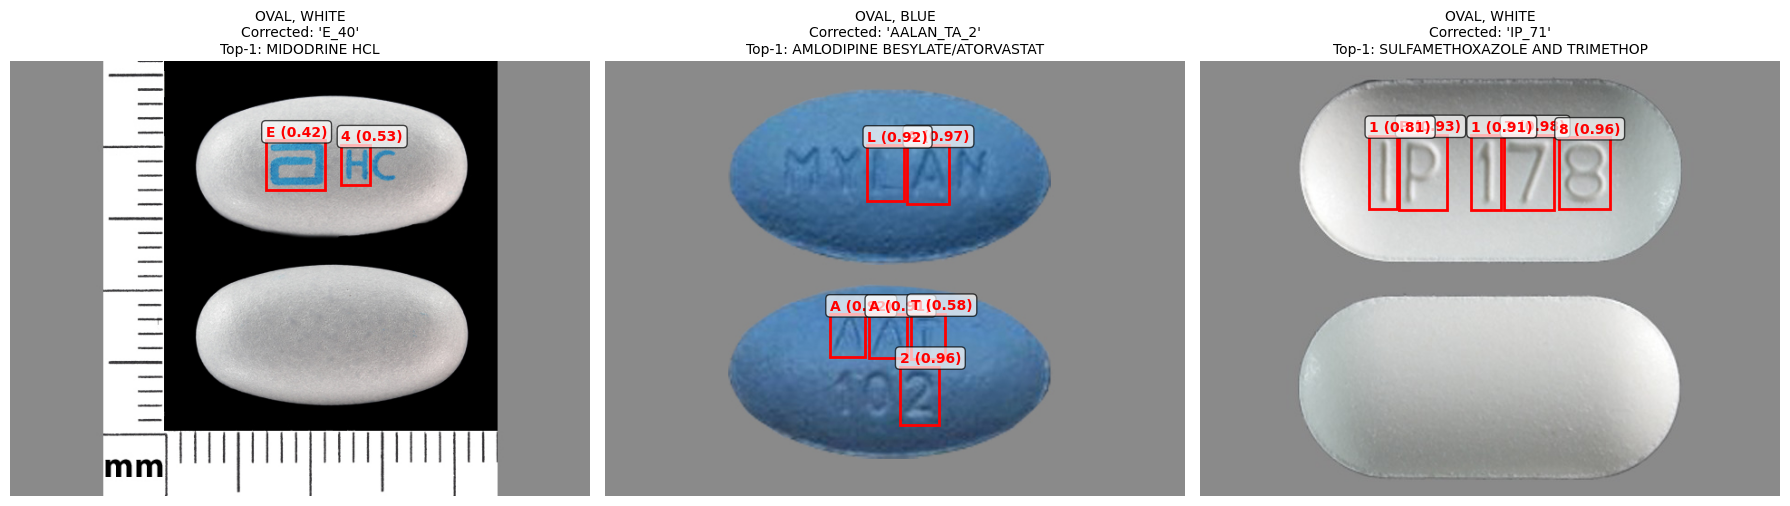

✓ Visualization saved to validation_preview.jpg


In [9]:
# Visualize first 3 predictions with YOLO detections
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, ax in enumerate(axes):
    img_name = results_df.iloc[idx]['image_name']
    img_path = image_dir / img_name
    
    # Load image and run prediction again to get detections
    image = Image.open(img_path)
    prediction = predict_pill(img_path)
    
    # Display image
    ax.imshow(image)
    
    # Draw YOLO bounding boxes
    img_width, img_height = image.size
    for det in prediction['yolo_detections']:
        x_center, y_center, w, h = det['bbox']
        x = (x_center - w/2) * img_width
        y = (y_center - h/2) * img_height
        
        rect = patches.Rectangle(
            (x, y), w * img_width, h * img_height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            x, y - 5, f"{det['class_name']} ({det['confidence']:.2f})",
            color='red', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )
    
    ax.axis('off')
    ax.set_title(
        f"{prediction['shape']}, {prediction['color']}\n"
        f"Corrected: '{prediction['imprint']}'\n"
        f"Top-1: {results_df.iloc[idx]['top1_medicine'][:30]}",
        fontsize=10
    )

plt.tight_layout()
plt.savefig('validation_preview.jpg', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to validation_preview.jpg")

## 10. Calculate Accuracy (Top-1 and Top-3)

In [10]:
# Create lookup dictionary: image_name -> medicine_name
ground_truth_lookup = dict(zip(database["image_name"], database["medicine_name"]))

# Add ground truth labels to results
results_df["true_medicine"] = results_df["image_name"].map(ground_truth_lookup)

# Calculate Top-1 Accuracy
top1_correct = (results_df["true_medicine"] == results_df["top1_medicine"]).sum()
top1_accuracy = top1_correct / len(results_df)

# Calculate Top-3 Accuracy
top3_correct = (
    (results_df["true_medicine"] == results_df["top1_medicine"]) |
    (results_df["true_medicine"] == results_df["top2_medicine"]) |
    (results_df["true_medicine"] == results_df["top3_medicine"])
).sum()
top3_accuracy = top3_correct / len(results_df)

# Display accuracy results
print("\n" + "="*80)
print("ACCURACY EVALUATION")
print("="*80)
print(f"Total images evaluated: {len(results_df)}")
print(f"Images with ground truth: {results_df["true_medicine"].notna().sum()}")
print(f"\nTop-1 Accuracy: {top1_accuracy:.4f} ({top1_correct}/{len(results_df)})")
print(f"Top-3 Accuracy: {top3_accuracy:.4f} ({top3_correct}/{len(results_df)})")
print("="*80)

# Show some examples of correct and incorrect predictions
print("\n" + "-"*80)
print("CORRECT PREDICTIONS (Top-1)")
print("-"*80)
correct_preds = results_df[results_df["true_medicine"] == results_df["top1_medicine"]].head(5)
for i, row in correct_preds.iterrows():
    print(f"✓ {row["image_name"]}")
    print(f"  True: {row["true_medicine"]}")
    print(f"  Pred: {row["top1_medicine"]} (score: {row["top1_score"]:.3f})")
    print()

print("-"*80)
print("INCORRECT PREDICTIONS (Top-1)")
print("-"*80)
incorrect_preds = results_df[results_df["true_medicine"] != results_df["top1_medicine"]].head(5)
for i, row in incorrect_preds.iterrows():
    print(f"✗ {row["image_name"]}")
    print(f"  True: {row["true_medicine"]}")
    print(f"  Pred: {row["top1_medicine"]} (score: {row["top1_score"]:.3f})")
    print(f"  Top-3: {row["top2_medicine"][:30]}, {row["top3_medicine"][:30]}")
    print()


ACCURACY EVALUATION
Total images evaluated: 741
Images with ground truth: 741

Top-1 Accuracy: 0.2348 (174/741)
Top-3 Accuracy: 0.3549 (263/741)

--------------------------------------------------------------------------------
CORRECT PREDICTIONS (Top-1)
--------------------------------------------------------------------------------
✓ 003786169.jpg
  True: AMLODIPINE BESYLATE/ATORVASTATIN CALCIUM
  Pred: AMLODIPINE BESYLATE/ATORVASTATIN CALCIUM (score: 1.680)

✓ 009046345.jpg
  True: METFORMIN HYDROCHLORIDE
  Pred: METFORMIN HYDROCHLORIDE (score: 2.667)

✓ 00603-5337-32_RXNAVIMAGE10_6C12B645.jpg
  True: PREDNISONE
  Pred: PREDNISONE (score: 2.667)

✓ 510790869.jpg
  True: VERAPAMIL HYDROCHLORIDE
  Pred: VERAPAMIL HYDROCHLORIDE (score: 2.267)

✓ 001439929.jpg
  True: CIPROFLOXACIN
  Pred: CIPROFLOXACIN (score: 2.022)

--------------------------------------------------------------------------------
INCORRECT PREDICTIONS (Top-1)
----------------------------------------------------------

## 11. Save Results

In [11]:
# Save results to CSV
results_df.to_csv('pipeline_results.csv', index=False)
print(f"✓ Results saved to pipeline_results.csv ({len(results_df)} rows)")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total images processed: {len(results_df)}")
print(f"Average top-1 score: {results_df['top1_score'].mean():.3f}")
print(f"Average top-3 score: {results_df[['top1_score', 'top2_score', 'top3_score']].mean().mean():.3f}")
print(f"\nTop-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"\nScore distribution:")
print(results_df['top1_score'].describe())

✓ Results saved to pipeline_results.csv (741 rows)

SUMMARY STATISTICS
Total images processed: 741
Average top-1 score: 2.096
Average top-3 score: 2.030

Top-1 Accuracy: 0.2348
Top-3 Accuracy: 0.3549

Score distribution:
count    741.000000
mean       2.096439
std        0.281061
min        0.666667
25%        1.893939
50%        2.075758
75%        2.333333
max        2.666667
Name: top1_score, dtype: float64
